In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo
%matplotlib inline
plt.style.use('ggplot')

## 导入数据

In [7]:
#连接数据库，导入数据
Host = 'yourhost'
DB = 'yourdb'
Collection = 'yourcollection'
user = 'username'
password = 'password'
client = pymongo.MongoClient(host=Host)
db = client[DB]
db.authenticate(user,password)
collection = db[Collection]
data = list(collection.find())
data = pd.DataFrame(data)
data.head()

,_id,rating,text
0,5c7a46091750c800e4519c5b,5.0,网红店，很出名，天天排队规模吓人，不过幸亏小伙伴肯提前占位，我们蹭个热门，一过去就有得吃 ...
1,5c7a46091750c800e4519c5c,5.0,那不是锅打边炉上海开了N家分店，这次选择金桥的，依旧排队厉害，好不容易排到我们，坐下开吃啦。...
2,5c7a46091750c800e4519c5d,5.0,终于吃到了 一直排队几小时 为了不排队深夜去吃的 虽然有很多连锁店还是去了金桥店 好像是第...
3,5c7a46091750c800e4519c5e,5.0,"终于抽空和火锅""真爱""们拔草这家店啦 一直听说这家店的性价比超高，果然名不虚传啊，食材新鲜，..."
4,5c7a46091750c800e4519c5f,4.0,前几天看到朋友圈有人晒他们家，说是平价版楼上火锅，味道差远了。其实我觉得两家店定价差那么多，...


### 其中rating为抓取的店铺分数/五分制，text为处理后的评论文本

In [8]:
del data['_id']
data.shape

(2000, 2)

### 共抓取某家餐厅2000条评论数据

In [9]:
test_data = data.iloc[0,:]
test_data

rating                                                    5
text      网红店，很出名，天天排队规模吓人，不过幸亏小伙伴肯提前占位，我们蹭个热门，一过去就有得吃  ...
Name: 0, dtype: object

In [11]:
#选一条数据查看评论内容
test_data['text']

'网红店，很出名，天天排队规模吓人，不过幸亏小伙伴肯提前占位，我们蹭个热门，一过去就有得吃  店里海鲜主打，真是大开眼界，一个个生龙活虎，竹蛏王这个吃过，没见过会动的…… 小鲍鱼，也是一碰就动起来了，特别好玩 虾🦐已经在竹签上，脚还在跑，都是活的  火锅最特别，炭火下面烧🔥，上面陶瓷锅，感觉就是在家里吃海鲜，特别不一样，不用电磁炉味道就是别具一格，价格很实惠，这个也难怪生意会这么好了……'

In [12]:
#对一条评论测试结巴分词效果
import jieba
jieba_test = jieba.cut(test_data['text'])
jieba_data = ' '.join(jieba_test)
jieba_data

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\mw\AppData\Local\Temp\jieba.cache
Loading model cost 1.102 seconds.
Prefix dict has been built succesfully.


'网红店 ， 很 出名 ， 天天 排队 规模 吓人 ， 不过 幸亏 小伙伴 肯 提前 占位 ， 我们 蹭 个 热门 ， 一 过去 就 有 得 吃     店里 海鲜 主打 ， 真是 大开眼界 ， 一个个 生龙活虎 ， 竹 蛏 王 这个 吃 过 ， 没见 过会动 的 … …   小 鲍鱼 ， 也 是 一 碰 就 动 起来 了 ， 特别 好玩   虾 🦐 已经 在 竹签 上 ， 脚 还 在 跑 ， 都 是 活 的     火锅 最 特别 ， 炭火 下面 烧 🔥 ， 上面 陶瓷 锅 ， 感觉 就是 在 家里 吃海鲜 ， 特别 不 一样 ， 不用 电磁炉 味道 就是 别具一格 ， 价格 很 实惠 ， 这个 也 难怪 生意 会 这么 好 了 … …'

## 数据处理

In [13]:
#生成评论字数变量len(text)
data['len(text)'] = data['text'].apply(lambda x:len(x))
data.head()

,rating,text,len(text)
0,5.0,网红店，很出名，天天排队规模吓人，不过幸亏小伙伴肯提前占位，我们蹭个热门，一过去就有得吃 ...,194
1,5.0,那不是锅打边炉上海开了N家分店，这次选择金桥的，依旧排队厉害，好不容易排到我们，坐下开吃啦。...,468
2,5.0,终于吃到了 一直排队几小时 为了不排队深夜去吃的 虽然有很多连锁店还是去了金桥店 好像是第...,322
3,5.0,"终于抽空和火锅""真爱""们拔草这家店啦 一直听说这家店的性价比超高，果然名不虚传啊，食材新鲜，...",297
4,4.0,前几天看到朋友圈有人晒他们家，说是平价版楼上火锅，味道差远了。其实我觉得两家店定价差那么多，...,563


In [15]:
#因为是五分制，所以只有五种分值，且都是整数分
data['rating'].value_counts()

5.0    1197
4.0     577
3.0     146
1.0      46
2.0      34
Name: rating, dtype: int64

### 因为评分只有5种情况，虽然是数值但却和分类变量一样，而实际每个人心里的评分应该都是有高有低不全一样的，所以在原来评分的基础上进行一些分数加减，让每个消费者的评分都有差异性。

### 分数策略：先分别计算每类评分对应评论的平均字数，然后用这个均值和对应评论字数相减求差值，接着用差值除以两者较大的一个再进行绝对值处理，最后得到的是一个0到1直接的小数，保留四位小数点，称为中间数。

### 在评论平台的划分是，四分五分的为好评，三分的为中评，一分二分的为差评。则以此为依据，如果评分是好评，则在原来的基础上加上中间数；如果是差评，则减去中间数；如果是中评，则随机加减中间数。

In [16]:
#生成对应评分级别的平均字数字典
map_dict = dict()
for score in [1.0,2.0,3.0,4.0,5.0]:
    temp_data = data[data['rating'] == score]
    temp_len = len(temp_data)
    temp_sum = sum(temp_data['len(text)'])
    map_dict[score] = int(temp_sum/temp_len)
map_dict

{1.0: 139, 2.0: 171, 3.0: 173, 4.0: 166, 5.0: 156}

In [61]:
#安照分数策略生成新的评分
import random
def get_rating(df):
    middle_data = abs(round((map_dict[df['rating']] - df['len(text)'])/max(map_dict[df['rating']],df['len(text)']),4))
    if df['rating'] > 3:
        new_rating = df['rating'] + middle_data
    if df['rating'] < 3:
        new_rating = df['rating'] - middle_data
    if df['rating'] == 3:
        new_rating = df['rating'] + random.choice([-1,1])*middle_data
    return new_rating

In [40]:
#生成新评分展示
data['score'] = data.apply(get_rating,axis=1)
data.head()

,rating,text,len(text),score,comment
0,5.0,网红店，很出名，天天排队规模吓人，不过幸亏小伙伴肯提前占位，我们蹭个热门，一过去就有得吃 ...,194,5.1959,网红店 ， 很 出名 ， 天天 排队 规模 吓人 ， 不过 幸亏 小伙伴 肯 提前 占位 ，...
1,5.0,那不是锅打边炉上海开了N家分店，这次选择金桥的，依旧排队厉害，好不容易排到我们，坐下开吃啦。...,468,5.6667,那 不是 锅 打 边炉 上海 开 了 N 家 分店 ， 这次 选择 金桥 的 ， 依旧 排队...
2,5.0,终于吃到了 一直排队几小时 为了不排队深夜去吃的 虽然有很多连锁店还是去了金桥店 好像是第...,322,5.5155,终于 吃 到 了 一直 排队 几小时 为了 不 排队 深夜 去 吃 的 虽然...
3,5.0,"终于抽空和火锅""真爱""们拔草这家店啦 一直听说这家店的性价比超高，果然名不虚传啊，食材新鲜，...",297,5.4747,"终于 抽空 和 火锅 "" 真 爱 "" 们 拔草 这家 店 啦 一直 听说 这家 店 的 ..."
4,4.0,前几天看到朋友圈有人晒他们家，说是平价版楼上火锅，味道差远了。其实我觉得两家店定价差那么多，...,563,4.7052,前 几天 看到 朋友圈 有人 晒 他们 家 ， 说 是 平价 版 楼上 火锅 ， 味道 差远...


In [34]:
#对原有评论文本做结巴分词处理生成新变量comment
def get_text(text):
    jieba_test = jieba.cut(text)
    jieba_data = ' '.join(jieba_test)
    return jieba_data

In [35]:
data['comment'] = data['text'].apply(get_text)
data.head()

,rating,text,len(text),score,comment
0,5.0,网红店，很出名，天天排队规模吓人，不过幸亏小伙伴肯提前占位，我们蹭个热门，一过去就有得吃 ...,194,5.1959,网红店 ， 很 出名 ， 天天 排队 规模 吓人 ， 不过 幸亏 小伙伴 肯 提前 占位 ，...
1,5.0,那不是锅打边炉上海开了N家分店，这次选择金桥的，依旧排队厉害，好不容易排到我们，坐下开吃啦。...,468,5.6667,那 不是 锅 打 边炉 上海 开 了 N 家 分店 ， 这次 选择 金桥 的 ， 依旧 排队...
2,5.0,终于吃到了 一直排队几小时 为了不排队深夜去吃的 虽然有很多连锁店还是去了金桥店 好像是第...,322,5.5155,终于 吃 到 了 一直 排队 几小时 为了 不 排队 深夜 去 吃 的 虽然...
3,5.0,"终于抽空和火锅""真爱""们拔草这家店啦 一直听说这家店的性价比超高，果然名不虚传啊，食材新鲜，...",297,5.4747,"终于 抽空 和 火锅 "" 真 爱 "" 们 拔草 这家 店 啦 一直 听说 这家 店 的 ..."
4,4.0,前几天看到朋友圈有人晒他们家，说是平价版楼上火锅，味道差远了。其实我觉得两家店定价差那么多，...,563,4.7052,前 几天 看到 朋友圈 有人 晒 他们 家 ， 说 是 平价 版 楼上 火锅 ， 味道 差远...


(array([  5.,   2.,   5.,   5.,   4.,   5.,   3.,   4.,   6.,   1.,   2.,
          2.,   1.,   0.,   1.,   0.,   0.,   1.,   2.,   3.,   4.,   4.,
          1.,   1.,   4.,   2.,   1.,   3.,   1.,   1.,   2.,   4.,   0.,
          2.,   3.,   6.,   5.,   2.,   1.,   3.,   5.,   2.,  10.,   6.,
         10.,   5.,   6.,   1.,   5.,   6.,   3.,   6.,   6.,   6.,   6.,
         10.,   5.,   0.,   3.,   2.,   3.,   5.,   4.,   5.,   3.,   1.,
         23.,  37.,  47.,  40.,  49.,  57.,  57.,  41.,  25.,  32.,  20.,
         22.,  17.,  26.,  30.,  43.,  11.,  32.,  90.,  98., 101., 130.,
        117., 124.,  52.,  46.,  48.,  46.,  51.,  48.,  49.,  45.,  86.,
         34.]),
 array([0.1367 , 0.19482, 0.25294, 0.31106, 0.36918, 0.4273 , 0.48542,
        0.54354, 0.60166, 0.65978, 0.7179 , 0.77602, 0.83414, 0.89226,
        0.95038, 1.0085 , 1.06662, 1.12474, 1.18286, 1.24098, 1.2991 ,
        1.35722, 1.41534, 1.47346, 1.53158, 1.5897 , 1.64782, 1.70594,
        1.76406, 1.82218, 1.8803 ,

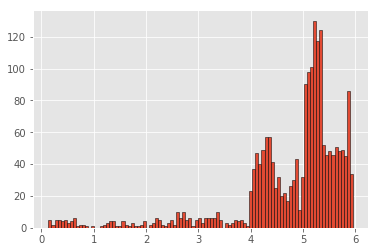

In [42]:
#新评分直方图查看
plt.hist(data['score'],bins=100,edgecolor='k')

## 使用TfidfVectorizer和LinearRegression进行评论和评分直接的建模分析

In [45]:
#导入停用词表
with open('stopwords.txt','r') as fa:
    stopwords = fa.read()
    #print(stopwords)
    stopwords_list = stopwords.split()
    print(stopwords_list)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '--', '.', '..', '...', '......', '...................', './', '.一', '.数', '.日', '/', '//', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '://', '::', ';', '<', '=', '>', '>>', '?', '@', 'A', 'Lex', '[', '\\', ']', '^', '_', '`', 'exp', 'sub', 'sup', '|', '}', '~', '~~~~', '·', '×', '×××', 'Δ', 'Ψ', 'γ', 'μ', 'φ', 'φ．', 'В', '—', '——', '———', '‘', '’', '’‘', '“', '”', '”，', '…', '……', '…………………………………………………③', '′∈', '′｜', '℃', 'Ⅲ', '↑', '→', '∈［', '∪φ∈', '≈', '①', '②', '②ｃ', '③', '③］', '④', '⑤', '⑥', '⑦', '⑧', '⑨', '⑩', '──', '■', '▲', '、', '。', '〈', '〉', '《', '》', '》），', '」', '『', '』', '【', '】', '〔', '〕', '〕〔', '㈧', '一', '一.', '一一', '一下', '一个', '一些', '一何', '一切', '一则', '一则通过', '一天', '一定', '一方面', '一旦', '一时', '一来', '一样', '一次', '一片', '一番', '一直', '一致', '一般', '一起', '一转眼', '一边', '一面', '七', '万一', '三', '三天两头', '三番两次', '三番五次', '上', '上下', '上升', '上去', '上来', '上述', '上面', '下', '下列', '下去', '下来', '下面', '不', '不一', '不下', '不久', '不了'

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [47]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words=stopwords_list)

In [48]:
comments = vectorizer.fit_transform(data['comment'])

In [49]:
linreg = LinearRegression()
linreg.fit(comments,data['score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
#eli5可视化展示评论词对于评分的影响程度
import eli5
eli5.show_weights(linreg, vec=vectorizer, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+3.293,期待
+3.036,太长
+2.947,一两个
+2.936,错
+2.639,超多
+2.492,好长时间
+2.465,热气
+2.463,时代
+2.410,亲民
+2.355,家门口


### 结论：该餐厅吸引消费者的原因主要有亲民，离家近，吃起来爽口，还有很多人第一次去很期待。而不足的地方主要有管理混乱，发票问题，态度不好，以及牛羊肉可能味道不太好。

In [56]:
#抽一条评论展示
print('评分:', data['score'][1])
eli5.show_prediction(linreg, doc=data['comment'].values[1], vec=vectorizer)

评分: 5.6667
